# Using Parallel Computing in fmdtools

This notebook will discuss how to use parallel programming in fmdtools, including:
- how to set up a model for parallelism
- syntax for using parallelism in simulation functions
- considerations for optimizing computational performance in a model

In [1]:
import sys
paths = sys.path
if paths[1]!='../':
    sys.path=[sys.path[0]] + ['../'] + paths

from ex_pump import * 
from fmdtools.modeldef import SampleApproach
import fmdtools.faultsim.propagate as propagate
import fmdtools.resultdisp as rd

This notebook uses the pump example (see ex_pump.py) to illustrate the use of parallelism in fmdtools. This is fairly simple model, and thus it should be noted that there may be considerations with more complex models which may not be adequately covered here.

In [2]:
mdl = Pump()

In [3]:
endresults, resgraph, mdlhist = propagate.nominal(mdl)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1daf7ab7788>)

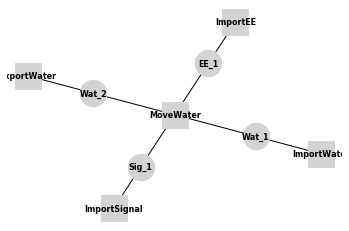

In [4]:
rd.graph.show(resgraph)

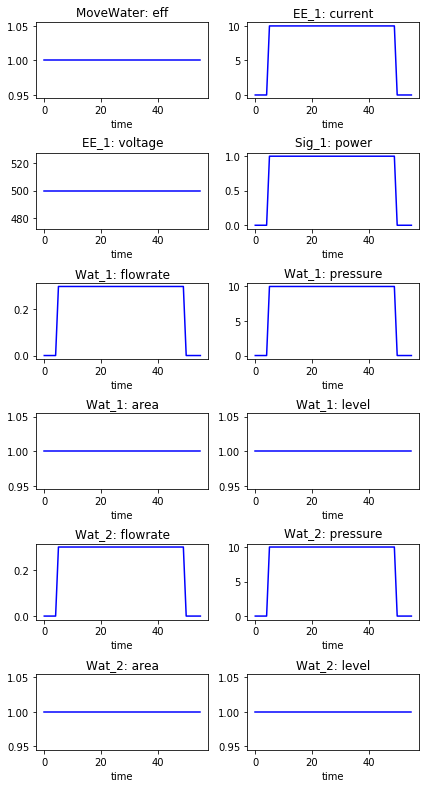

In [5]:
rd.plot.mdlhistvals(mdlhist)

## Model Checks

Before attempting to leverage parallelism in model execution, it can be helpful to check whether a model is compatible with python parallel computing libraries. In order for a model to be parallelized, it must be compatible with [pickling](https://docs.python.org/3/library/pickle.html#:~:text=%E2%80%9CPickling%E2%80%9D%20is%20the%20process%20whereby,back%20into%20an%20object%20hierarchy.)--python's method of data serialization. This is used in parallel programming methods to copy the model from the main process thread to the seperate processes of the pool.

fmdtools has two methods to check whether a model can be pickled, `check_pickleability` and `check_model_pickleability`. The main difference between these is that `check_pickleability` works for all objects (e.g. functions and flows), while `check_model_pickleability` gives more information for an overall model structure

In [6]:
from fmdtools.modeldef import check_pickleability, check_model_pickleability

In [7]:
unpickleable_attributes = check_pickleability(mdl)

The object is pickleable


In [8]:
check_model_pickleability(mdl)

The object is pickleable


As you can see, this model is pickleable. However, this may not be the case for all structures if they rely on unpickleable data structures. For example:

In [9]:
mdl.fxns['ImportEE'].bad_fxn_attribute = {1:2,3:4}.keys()
mdl.flows['EE_1'].bad_flow_attribute = {1:2,3:4}.keys()

In [10]:
check_model_pickleability(mdl)

The following attributes will not pickle: ['flows', 'fxns', 'graph']
FLOWS 
EE_1
The following attributes will not pickle: ['bad_flow_attribute']
Sig_1
The object is pickleable
Wat_1
The object is pickleable
Wat_2
The object is pickleable
FUNCTIONS 
ImportEE
The following attributes will not pickle: ['flows', 'EEout', 'bad_fxn_attribute']
ImportWater
The object is pickleable
ImportSignal
The object is pickleable
MoveWater
The following attributes will not pickle: ['flows', 'EEin']
ExportWater
The object is pickleable


In this case, because the `ImportEE` function and `EE_1` flow was given a an unpicklable attribute (a `dict_keys()` object) and thus the interfacing functions and overall model will not pickle. To fix this, one could easily convert these attributes into lists, sets, or dictionaries.

In [11]:
mdl = Pump()

## Using Parallelism in Simulation

Parallelism generally requires using some external parallel processing toolkit. The syntax used by fmdtools methods is compatible with:
- [multiprocessing](https://docs.python.org/3/library/multiprocessing.html), python's default parallel computing library
- [multiprocess](https://pypi.org/project/multiprocess/), a fork of multiprocessing developed by The UQ Foundation
- [pathos](https://github.com/uqfoundation/pathos), a broader parallel computing package developed by The UQ Foundation

And any other package that emulates multiprocessing.Pool

In [12]:
import multiprocessing as mp
import multiprocess as ms
from pathos.pools import ParallelPool, ProcessPool, SerialPool, ThreadPool

Parallelism can speed up simulation time when there is a large number of independent simulations to run. The main interface for using parallelism is thus using the `run_singlefaults` (usually used in static models) and `run_approach` methods. They can be run in parallel by sending them a `pool` object from one of these modules as the optional `pool` argument.

In [13]:
pool = mp.Pool(4)
app = SampleApproach(mdl)
endclasses, mdlhists = propagate.approach(mdl,app, pool=pool)
rd.tabulate.simplefmea(endclasses)

SCENARIOS COMPLETE: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.74it/s]


,rate,cost,expected cost
"ImportEE no_v, t=27",0.000360,15175.00,546300.000000
"ImportEE inf_v, t=27",0.000090,20175.00,181575.000000
"ImportWater no_wat, t=27",0.000150,6175.00,92625.000000
"ImportSignal no_sig, t=27",0.000013,15175.00,19510.714286
"MoveWater mech_break, t=27",0.000231,10175.00,235478.571429
"MoveWater short, t=27",0.000129,25175.00,323678.571429
"ExportWater block, t=27",0.000129,15150.25,194788.928571
"ImportWater no_wat, t=2",0.000017,11125.00,18541.666667
"ImportSignal no_sig, t=2",0.000002,20125.00,4312.500000
"MoveWater mech_break, t=2",0.000002,15125.00,3241.071429


In [14]:
pool = mp.Pool(4)
endclasses, mdlhists = propagate.single_faults(mdl,app, pool=pool)
rd.tabulate.simplefmea(endclasses)

SCENARIOS COMPLETE: 100%|██████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 13.41it/s]


,rate,cost,expected cost
"ImportEE no_v, t=0",0.000448,20125.00,901600.0
"ImportEE inf_v, t=0",0.000112,25125.00,281400.0
"ImportWater no_wat, t=0",0.000560,11125.00,623000.0
"ImportSignal no_sig, t=0",0.000056,20125.00,112700.0
"MoveWater mech_break, t=0",0.000336,15125.00,508200.0
"MoveWater short, t=0",0.000560,30125.00,1687000.0
"ExportWater block, t=0",0.000560,20100.25,1125614.0
"ImportEE no_v, t=20",0.000448,16750.00,750400.0
"ImportEE inf_v, t=20",0.000112,21750.00,243600.0
"ImportWater no_wat, t=20",0.000560,7750.00,434000.0


It can also be helpful to verify that the results of parallel simulation and normal serial execution are the same:

In [15]:
endclasses_par, mdlhists = propagate.single_faults(mdl, pool=pool)
tab_par = rd.tabulate.simplefmea(endclasses_par)
endclasses, mdlhists = propagate.single_faults(mdl)
tab = rd.tabulate.simplefmea(endclasses)
tab - tab_par

SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 221.78it/s]


,rate,cost,expected cost
"ImportEE no_v, t=0",0.0,0.0,0.0
"ImportEE inf_v, t=0",0.0,0.0,0.0
"ImportWater no_wat, t=0",0.0,0.0,0.0
"ImportSignal no_sig, t=0",0.0,0.0,0.0
"MoveWater mech_break, t=0",0.0,0.0,0.0
"MoveWater short, t=0",0.0,0.0,0.0
"ExportWater block, t=0",0.0,0.0,0.0
"ImportEE no_v, t=20",0.0,0.0,0.0
"ImportEE inf_v, t=20",0.0,0.0,0.0
"ImportWater no_wat, t=20",0.0,0.0,0.0


In [16]:
endclasses_par, mdlhists = propagate.approach(mdl, app, pool=pool)
tab_par = rd.tabulate.simplefmea(endclasses_par)
endclasses, mdlhists = propagate.approach(mdl, app)
tab = rd.tabulate.simplefmea(endclasses)
tab - tab_par

SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 221.52it/s]


,rate,cost,expected cost
"ImportEE no_v, t=27",0.0,0.0,0.0
"ImportEE inf_v, t=27",0.0,0.0,0.0
"ImportWater no_wat, t=27",0.0,0.0,0.0
"ImportSignal no_sig, t=27",0.0,0.0,0.0
"MoveWater mech_break, t=27",0.0,0.0,0.0
"MoveWater short, t=27",0.0,0.0,0.0
"ExportWater block, t=27",0.0,0.0,0.0
"ImportWater no_wat, t=2",0.0,0.0,0.0
"ImportSignal no_sig, t=2",0.0,0.0,0.0
"MoveWater mech_break, t=2",0.0,0.0,0.0


While fmdtools built-in methods are the easiest way to leverage parallelism, it can also be used with custom arguments/methods to meet the needs of simulation. However, (on Windows) these methods need to be defined in an external module with an "if __name__=='__main__':" statement, otherwise execution will hang from spawning new processes. This has to do with how multiprocessing works in windows.

Below the model is run over the blockage fault mode at time t=1 with a different model parameter (delayed failure behavior), as defined in the `parallelism_methods.py` module in this folder.

In [17]:
from parallelism_methods import delay_test

In [18]:
results = delay_test()

In [19]:
results

[{'flows': {'Wat_2': {'area': 0.01}},
  'faults': {'MoveWater': ['mech_break'], 'ExportWater': ['block']},
  'classification': {'rate': 0.00055,
   'cost': 20125.000000000007,
   'expected cost': 1106875.0000000005}},
 {'flows': {'Wat_2': {'area': 0.01}},
  'faults': {'MoveWater': ['mech_break'], 'ExportWater': ['block']},
  'classification': {'rate': 0.00055,
   'cost': 20100.250000000007,
   'expected cost': 1105513.7500000005}},
 {'flows': {'Wat_2': {'area': 0.01}},
  'faults': {'MoveWater': ['mech_break'], 'ExportWater': ['block']},
  'classification': {'rate': 0.00055,
   'cost': 20077.750000000007,
   'expected cost': 1104276.2500000005}},
 {'flows': {'Wat_2': {'area': 0.01}},
  'faults': {'MoveWater': ['mech_break'], 'ExportWater': ['block']},
  'classification': {'rate': 0.00055,
   'cost': 20055.250000000007,
   'expected cost': 1103038.7500000005}},
 {'flows': {'Wat_2': {'area': 0.01}},
  'faults': {'MoveWater': ['mech_break'], 'ExportWater': ['block']},
  'classification': {

## Performance Comparison

Parallelism is often used in computation to speed up up a set of independent simulations. Conventionally, one might say it leads to a reduced computational cost of $t/n$, where t was the original time of the set of processes, and n is the number of cores.

However, this computational performance increase is dependent on the implementation. In Python, there is some overhead from 
from communicating data structures in and out of parallel threads which can become a significant consideration when the data structures are large. Additionally, different Pools can execute more or less efficiently. Below these are each compared.

In [20]:
import matplotlib.pyplot as plt
from parallelism_methods import compare_pools

In [21]:
cores=4
pools = {'multiprocessing':mp.Pool(cores), 'ProcessPool':ProcessPool(nodes=cores), 'ParallelPool': ParallelPool(nodes=cores), 'ThreadPool':ThreadPool(nodes=cores), 'multiprocess':ms.Pool(cores) }

Below is the baseline comparison, where the the following parameters characterize the sampling approach:
 - single faults: only the single-fault scenarios are considered
 - 3 points per phase: an evenly-spaced quadrature is sampled at each phase of operation (start, on, end) for the model
 - staged: the model is copied at each point in time where faults is injected during the model time to save computation
 - track: the entire model history is returned for each simulation
 
 This is typical for a small model like this where the per-model expense is low.

In [24]:
app = SampleApproach(mdl,jointfaults={'faults':1},defaultsamp={'samp':'evenspacing','numpts':3})
mdl=Pump(params={'cost':{'repair'}, 'delay':10}, modelparams = {'phases':{'start':[0,5], 'on':[5, 50], 'end':[50,55]}, 'times':[0,20, 55], 'tstep':1})
exectimes = compare_pools(mdl,app,pools, staged=True, track='all', verbose=False)
exectimes_baseline = exectimes

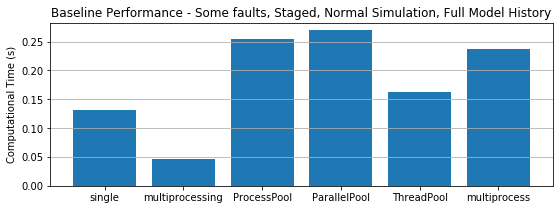

In [25]:
fig = plt.figure(figsize=(9, 3),)
plt.bar(range(len(exectimes)), list(exectimes.values()), align='center')
plt.xticks(range(len(exectimes)), list(exectimes.keys()))
plt.title("Baseline Performance - Some faults, Staged, Normal Simulation, Full Model History")
plt.ylabel("Computational Time (s)")
plt.grid(axis='y')

As shown, in this situation, both the multiprocessing and threadpool pools give computational performance increases.

### Comparison: No Histories

In the below comparison, the same simulation approach is run, except without tracking a history of model states through the simulation.

In [26]:
app = SampleApproach(mdl,jointfaults={'faults':1},defaultsamp={'samp':'evenspacing','numpts':3})
mdl=Pump(params={'cost':{'repair'}, 'delay':10}, modelparams = {'phases':{'start':[0,5], 'on':[5, 50], 'end':[50,55]}, 'times':[0,20, 55], 'tstep':1})
exectimes = compare_pools(mdl,app,pools, staged=True, track='none', verbose=False)

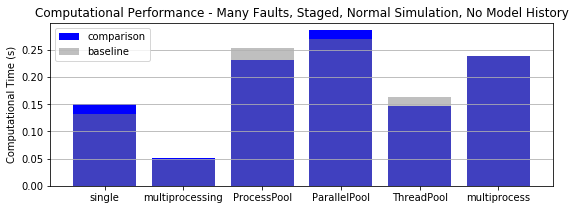

In [39]:
fig = plt.figure(figsize=(9, 3),)
width = 0.8
plt.bar(range(len(exectimes)), list(exectimes.values()), align='center', color="blue", label="comparison")
plt.bar(range(len(exectimes_baseline)), list(exectimes_baseline.values()), align='center', color="gray", alpha=0.5, label="baseline")
plt.xticks(range(len(exectimes)), list(exectimes.keys()))
plt.title("Computational Performance - Many Faults, Staged, Normal Simulation, No Model History")
plt.ylabel("Computational Time (s)")
plt.grid(axis='y')
plt.legend()

As shown, in this situation, the overall simulation expense decreases dramatically (~1/2), even in the serial execution case.

Additionally, the case for using a parallel processing pool increases immensely (the multiprocessing pool takes ~1/4 of the normal simulation time). This is because passing the model history back to the main process is nearly comparable in time to simulation itself.

As a result, removing it saves a large amount of computational time when using parallel processing.

### Comparison: Many Faults

In the below comparison, many faults are injected in the system to increase the number of scenarios (ostensibly making the case better for parallelism)

In [40]:
app = SampleApproach(mdl,jointfaults={'faults':5},defaultsamp={'samp':'evenspacing','numpts':3})
mdl=Pump(params={'cost':{'repair'}, 'delay':10}, modelparams = {'phases':{'start':[0,5], 'on':[5, 50], 'end':[50,55]}, 'times':[0,20, 55], 'tstep':1})
exectimes = compare_pools(mdl,app,pools, staged=True, track='None', verbose=False)

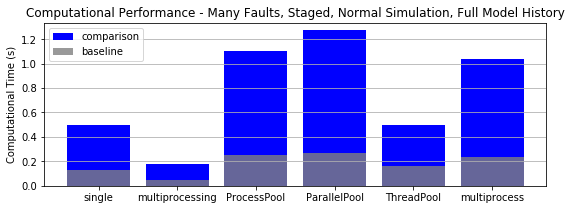

In [41]:
fig = plt.figure(figsize=(9, 3),)
width = 0.8
plt.bar(range(len(exectimes)), list(exectimes.values()), align='center', color="blue", label="comparison")
plt.bar(range(len(exectimes_baseline)), list(exectimes_baseline.values()), align='center', color="gray", alpha=0.8, label="baseline")
plt.xticks(range(len(exectimes)), list(exectimes.keys()))
plt.title("Computational Performance - Many Faults, Staged, Normal Simulation, Full Model History")
plt.ylabel("Computational Time (s)")
plt.grid(axis='y')
plt.legend()

As shown, increasing the number of joint-fault scenarios increases computational costs significantly--as would be expected.

In this situation, multiprocessing performs comparatively better, but only slightly--instead of taking 1/4 the time, it only takes about 1/2 the time.

### Comparison: Long simulation

It may be of interest to simulate how the comparative performance changes for longer simulations. In this comparison, the simulation time is extended tenfold.

In [42]:
app = SampleApproach(mdl,jointfaults={'faults':1},defaultsamp={'samp':'evenspacing','numpts':3})
mdl=Pump(params={'cost':{'repair'}, 'delay':10}, modelparams = {'phases':{'start':[0,5], 'on':[5, 50], 'end':[50,500]}, 'times':[0,20, 500], 'tstep':1})
exectimes = compare_pools(mdl,app,pools, staged=True, track="all", verbose=False)

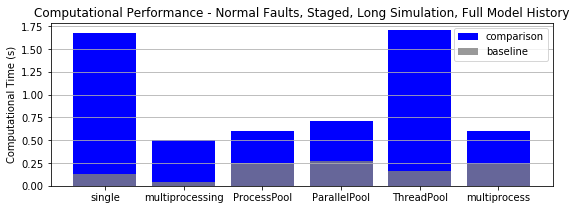

In [43]:
fig = plt.figure(figsize=(9, 3),)
width = 0.8
plt.bar(range(len(exectimes)), list(exectimes.values()), align='center', color="blue", label="comparison")
plt.bar(range(len(exectimes_baseline)), list(exectimes_baseline.values()), align='center', color="gray", alpha=0.8, label="baseline")
plt.xticks(range(len(exectimes)), list(exectimes.keys()))
plt.title("Computational Performance - Normal Faults, Staged, Long Simulation, Full Model History")
plt.ylabel("Computational Time (s)")
plt.grid(axis='y')
plt.legend()

As shown, the simulation time does increase significantly--about tenfold. In terms of comparative performance, the same general trends hold, except some pools take more of a performance decrease than others. Ostensibly because they require more computational overhead to copy larger data structures back to the main process.

### Comparison: Long Simulation No Tracking

Finally, it may be interesting to see how performance is affected in long simulations when there is no tracking. This is because in these simulations, there should be very little overhead from creating the respective data structures, even when there is a long simulation. This comparison is shown below.

In [44]:
app = SampleApproach(mdl,jointfaults={'faults':1},defaultsamp={'samp':'evenspacing','numpts':3})
mdl=Pump(params={'cost':{'repair'}, 'delay':10}, modelparams = {'phases':{'start':[0,5], 'on':[5, 50], 'end':[50,500]}, 'times':[0,20, 500], 'tstep':1})
exectimes = compare_pools(mdl,app,pools, staged=True, track='none', verbose=False)

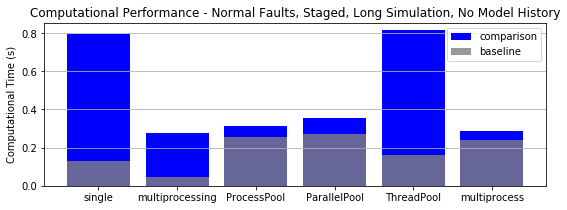

In [45]:
fig = plt.figure(figsize=(9, 3),)
width = 0.8
plt.bar(range(len(exectimes)), list(exectimes.values()), align='center', color="blue", label="comparison")
plt.bar(range(len(exectimes_baseline)), list(exectimes_baseline.values()), align='center', color="gray", alpha=0.8, label="baseline")
plt.xticks(range(len(exectimes)), list(exectimes.keys()))
plt.title("Computational Performance - Normal Faults, Staged, Long Simulation, No Model History")
plt.ylabel("Computational Time (s)")
plt.grid(axis='y')
plt.legend()

As shown, with a long simulation, the case for pools (other than multiprocessing--ProcessPool, ParallelPool, multiprocess) increases somewhat.

### Comparison: Long Simulation Only Necessary Tracking

In practice, it can be necessary to track some states over time. Here we perform the same comparison using the 'valstates' option, which only tracks states which have been defined in the model to be necessary to track (using 'valparams')

In [46]:
app = SampleApproach(mdl,jointfaults={'faults':1},defaultsamp={'samp':'evenspacing','numpts':3})
mdl=Pump(params={'cost':{'repair'}, 'delay':10}, modelparams = {'phases':{'start':[0,5], 'on':[5, 50], 'end':[50,500]}, 'times':[0,20, 500], 'tstep':1})
exectimes = compare_pools(mdl,app,pools, staged=True, track='valparams', verbose=False)

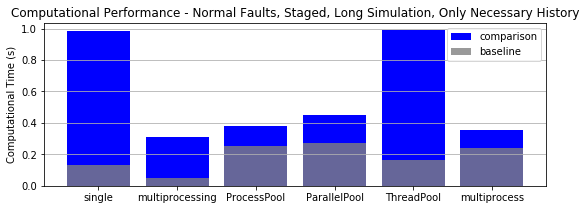

In [47]:
fig = plt.figure(figsize=(9, 3),)
width = 0.8
plt.bar(range(len(exectimes)), list(exectimes.values()), align='center', color="blue", label="comparison")
plt.bar(range(len(exectimes_baseline)), list(exectimes_baseline.values()), align='center', color="gray", alpha=0.8, label="baseline")
plt.xticks(range(len(exectimes)), list(exectimes.keys()))
plt.title("Computational Performance - Normal Faults, Staged, Long Simulation, Only Necessary History")
plt.ylabel("Computational Time (s)")
plt.grid(axis='y')
plt.legend()

As shown, even though this model has a large increase in simulation time, the this time can be reduced by not returning the full history.

Thus, the major computational performance limitation in this model is not necessarily the model, but the generation, update, and passing of the history itself.

## Comparison: Lower Tracking Time Resolution

Finally, the number of recorded timesteps can be lowered to lower computational costs while still returning all relevant variables.

In [49]:
app = SampleApproach(mdl,jointfaults={'faults':1},defaultsamp={'samp':'evenspacing','numpts':3})
mdl=Pump(params={'cost':{'repair'}, 'delay':10}, modelparams = {'phases':{'start':[0,5], 'on':[5, 50], 'end':[50,55]}, 'times':[0,20, 55], 'tstep':1})
exectimes = compare_pools(mdl,app,pools, staged=True, track='all', verbose=False, track_times=("interval", 5))

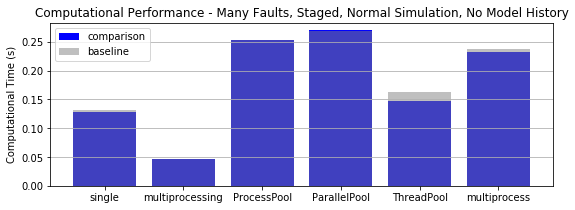

In [50]:
fig = plt.figure(figsize=(9, 3),)
width = 0.8
plt.bar(range(len(exectimes)), list(exectimes.values()), align='center', color="blue", label="comparison")
plt.bar(range(len(exectimes_baseline)), list(exectimes_baseline.values()), align='center', color="gray", alpha=0.5, label="baseline")
plt.xticks(range(len(exectimes)), list(exectimes.keys()))
plt.title("Computational Performance - Many Faults, Staged, Normal Simulation, No Model History")
plt.ylabel("Computational Time (s)")
plt.grid(axis='y')
plt.legend()

As shown, while lowering time resolution could theoretically lower computational time, it does not significantly change much in this example.

## Comparison Conclusions:

Parallelism can the improve computational performance of a given resilience simulation approach. However, this improvement is dependent on the parameters of the simulation. Generally, the official python `multiprocessing` module seems to be the only package that consistently gives a performance improvement over a single-process execution, although this can change depending on the underlying model and modelling approach. There are additionally reasons you might choose other pools--`Pathos` and `multiprocess` pools may enable more data structures in the model because they extend what can be communicated in and out of threads.

In general, one of the major considerations for optimization compuational time is not just the *simulation of the model*, but the *size of the returned data structures*. Minimizing the size of the returned data structures can reduce computational time both by reducing the time of an individual simulation and by reducing the *parallelism overhead* from copying these data structures in and out of parallel threads. However, it is important to recognize that for resilience assessment, one often needs a history of model states (or, at least, states of interest) to properly quantify the dynamic costs (i.e., $\int C_f(t) dt$). Indeed, in this model, only repair costs were able to be used in the comparison of non-tracked states, because the other dynamic costs required a history of their corresponding flows. Changing the number and size of tracked model states can influence the computational time, but only to a point--while one would expect lowering time-fidelity to have a significant effect, it does not because the overhead is less to do with filling the underlying data structures as it has to do with instantiating and returning them--a far more effective method is to only return the functions/flows which are needed by the model.